# Capstone Project

This is a sketchbook of information from the Capstone Project. 

In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Cleaning data and making sure it looks fine

In [30]:
# replace the path below with the actual path where you saved the file
df = pd.read_csv("default of credit card clients.csv", header=1)

print(df.head())   # shows the first 5 rows

   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0         0         0   

### Prepoccesing

In [31]:
df.info()  # shows the summary of the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [32]:
counts = df['default payment next month'].value_counts()

print(counts) #Biased data, maybe investigate it!

default payment next month
0    23364
1     6636
Name: count, dtype: int64


Here we see that the data looks fine

In [33]:
# First split: 70% train, 30% temp (val+test)
train, temp = train_test_split(df, test_size=0.3, random_state=42)

# Second split: 15% val, 15% test from temp
val, test = train_test_split(temp, test_size=0.5, random_state=42)

print(f"Train shape: {train.shape}")
print(f"Validation shape: {val.shape}")
print(f"Test shape: {test.shape}")

Train shape: (21000, 25)
Validation shape: (4500, 25)
Test shape: (4500, 25)


# EDA

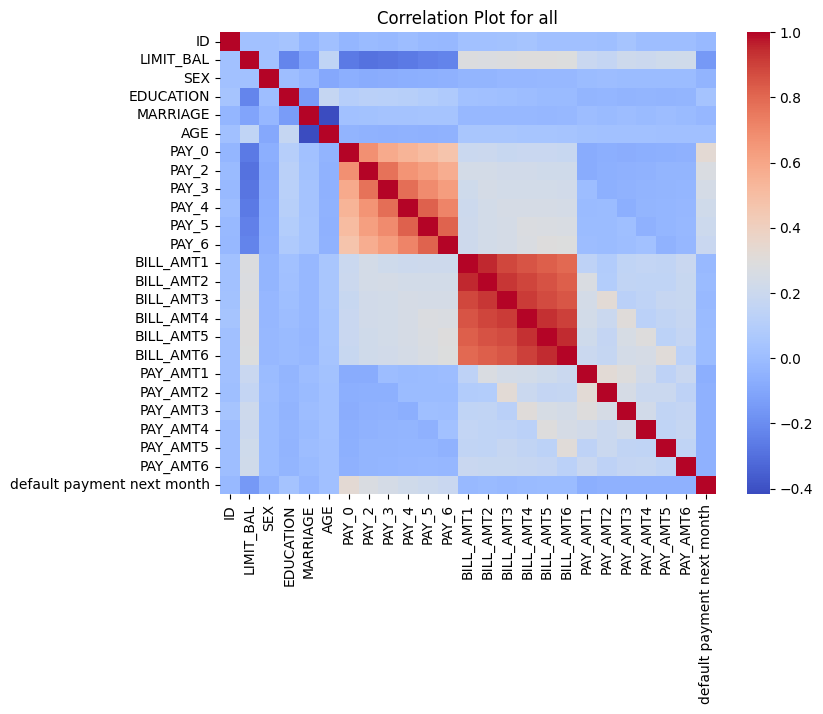

In [7]:
corr = train.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=False, cmap='coolwarm')  # no numbers
plt.title('Correlation Plot for all')
plt.show()

As I look at the data (BOTH BY THE CORRELATION PLOT AND KNOWLEDGE DOMAIN), I see four natural subset of covariates. From column 1 to 5 describes general information about the costumer. Column 6-11 describes history of past payment for different months. Column 12-17 describes amount of bill statement for different months. Column 18-23 describes amount of previous payment in different months. 

In [16]:
dfs = {
    'df_gen': train.iloc[:, 1:6],
    'df_pay': train.iloc[:, 7:12],
    'df_bill': train.iloc[:, 13:18],
    'df_pay_amt': train.iloc[:, 19:24]
}

df_gen = train.iloc[:, 1:6]
df_pay = train.iloc[:, 7:12]
df_bill = train.iloc[:, 13:18]
df_pay_amt = train.iloc[:, 19:24]


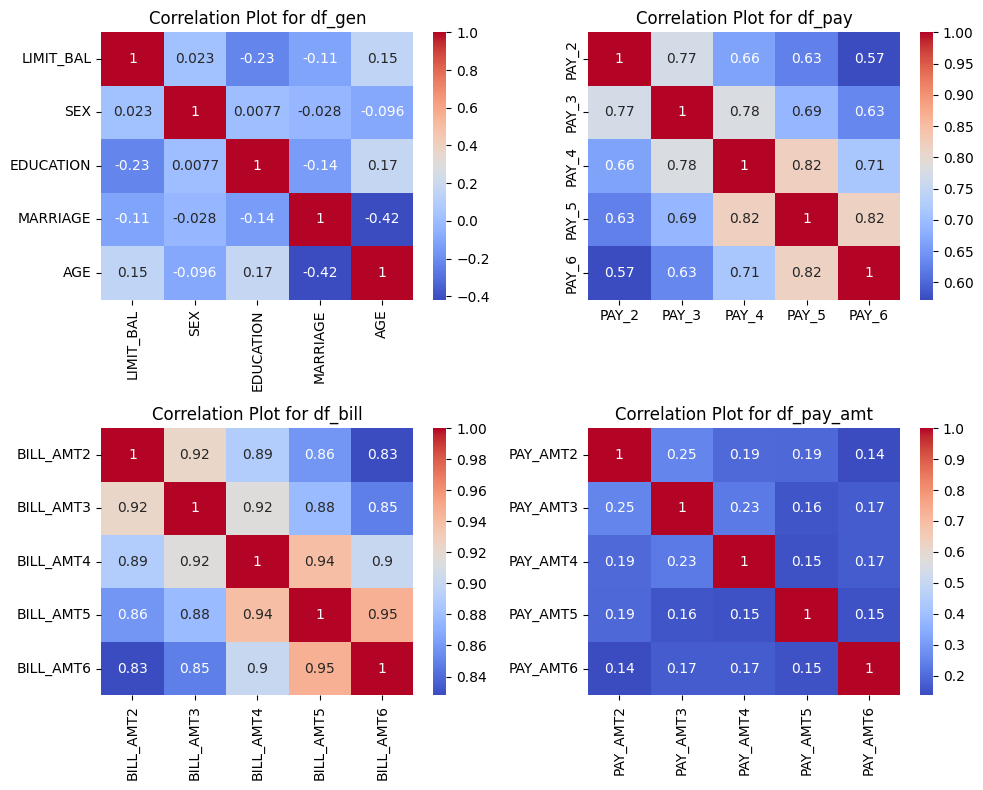

In [6]:

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through dataframes and plot heatmaps
for ax, (name, sub_df) in zip(axes, dfs.items()):
    corr = sub_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)
    ax.set_title(f'Correlation Plot for {name}')

plt.tight_layout()
plt.show()

In [ ]:
df_gen = train.iloc[:, 1:6]
df_pay = train.iloc[:, 7:12]
df_bill = train.iloc[:, 13:18]
df_pay_amt = train.iloc[:, 19:24]

# --- PCA for pay ---
scaler = StandardScaler()
df_pay_scaled = scaler.fit_transform(df_pay)
pca_pay = PCA()
df_pay_pca = pca_pay.fit_transform(df_pay_scaled)
df_pay_first = pd.DataFrame(df_pay_pca[:, [0]], columns=["PAY_PCA1"])

# --- PCA for bill ---
scaler = StandardScaler()
df_bill_scaled = scaler.fit_transform(df_bill)
pca_bill = PCA()
df_bill_pca = pca_bill.fit_transform(df_bill_scaled)
df_bill_first = pd.DataFrame(df_bill_pca[:, [0]], columns=["BILL_PCA1"])

# --- concatenate all parts into DataFrame ---
df_PCA_X = pd.concat(
    [df_gen.reset_index(drop=True),
     df_pay_first.reset_index(drop=True),
     df_bill_first.reset_index(drop=True),
     df_pay_amt.reset_index(drop=True)], 
    axis=1
)

print(df_PCA_X.head())

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_PCA1  BILL_PCA1  PAY_AMT2  \
0     240000    2          1         1   40 -3.406897  -1.504030         0   
1      50000    2          1         2   23 -1.496615  -1.361414      2321   
2      50000    2          2         1   36  2.666477   0.022715      4700   
3     200000    2          3         1   54  6.439848   1.326729         0   
4     240000    1          1         1   35 -1.098790  -0.959993     21817   

   PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
0         0         0         0         0  
1      4800      9810       660      2980  
2         0      2004      3500         0  
3         0         0         0         0  
4      1120     13434     22772     22820  


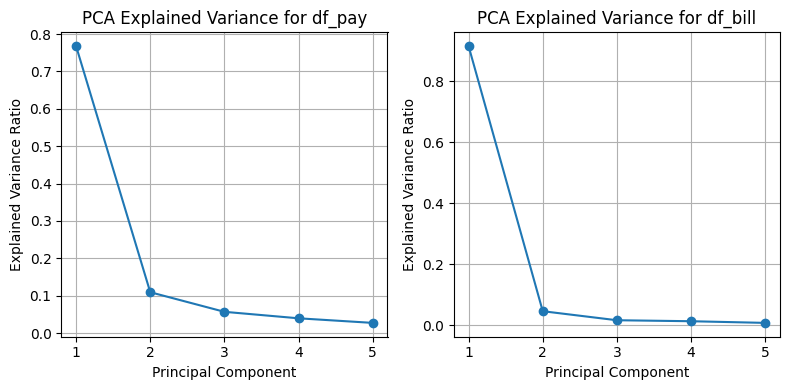

In [24]:
scaler = StandardScaler()
df_pay_scaled = scaler.fit_transform(df_pay)

pca_pay = PCA()
pca_pay.fit(df_pay_scaled)

# --- df_bill ---
scaler = StandardScaler()
df_bill_scaled = scaler.fit_transform(df_bill)

pca_bill = PCA()
pca_bill.fit(df_bill_scaled)

# --- Plot in 2x1 figure ---
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot df_pay
axes[0].plot(
    range(1, len(pca_pay.explained_variance_ratio_)+1),
    pca_pay.explained_variance_ratio_,
    marker='o'
)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA Explained Variance for df_pay')
axes[0].grid(True)

# Plot df_bill
axes[1].plot(
    range(1, len(pca_bill.explained_variance_ratio_)+1),
    pca_bill.explained_variance_ratio_,
    marker='o'
)
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Explained Variance Ratio')
axes[1].set_title('PCA Explained Variance for df_bill')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Making models

## No variable selection

In [141]:
# Features and target
X_train = train.iloc[:, 1:-1]
y_train = train.iloc[:, -1]

### KNN

In [142]:
# Grid search for best k using 5-fold CV
param_grid = {'n_neighbors': range(1, 21)}
knn = KNeighborsClassifier()
k_values = param_grid['n_neighbors']

# GridSearchCV for accuracy
grid_knn_acc = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_knn_acc.fit(X_train, y_train)

# GridSearchCV for sensitivity (recall)
grid_knn_rec = GridSearchCV(knn, param_grid, cv=5, scoring='recall')
grid_knn_rec.fit(X_train, y_train)

# For confusion matrix
best_knn = grid_knn_rec.best_estimator_



### Random Forest Model

In [143]:
# Initialize RandomForestClassifier and define parameter grid
param_grid_rf = {'n_estimators': range(20, 200, 20)}
rf = RandomForestClassifier(random_state=42)
n_values = param_grid_rf['n_estimators']

# GridSearchCV for accuracy
grid_rf_acc = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_rf_acc.fit(X_train, y_train)

# GridSearchCV for sensitivity (recall)
grid_rf_rec = GridSearchCV(rf, param_grid_rf, cv=5, scoring='recall')
grid_rf_rec.fit(X_train, y_train)

# For confusion matrix
best_rf = grid_rf_rec.best_estimator_


### SVM

In [144]:
param_grid_svm = {'C': [0.1, 1, 10]} #Descibes how much to penalize misclassifications. High C means low regularization (penalization).
svm = LinearSVC(random_state=42, max_iter=5000)
n_values = param_grid_svm['C']

# GridSearchCV for accuracy
grid_svm_acc = GridSearchCV(
    svm,
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,   # use all CPU cores
    verbose=3    # progress output
)

# Running the grid search
grid_svm_acc.fit(X_train, y_train)


# GridSearchCV for sensitivity (recall)
grid_svm_rec = GridSearchCV(
    svm,
    param_grid_svm,
    cv=5,
    scoring='recall',
    n_jobs=-1,   # use all CPU cores
    verbose=3    # progress output
)

# Running the grid search
grid_svm_rec.fit(X_train, y_train)


best_svm = grid_svm_rec.best_estimator_


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


### Logistic Regression

In [145]:
#### Linear regression with LASSO regularization
n_values_lasso = [0.1, 1, 10]

# LASSO logistic regression (L1 penalty)
lasso = LogisticRegressionCV(
    Cs=n_values_lasso, cv=5, penalty='l1', solver='saga', scoring='accuracy', max_iter=1000, random_state=42
)
lasso.fit(X_train, y_train)

# Sensitivity (recall) for LASSO
lasso_rec = LogisticRegressionCV(
    Cs=n_values_lasso, cv=5, penalty='l1', solver='saga', scoring=make_scorer(recall_score), max_iter=1000, random_state=42
)
lasso_rec.fit(X_train, y_train)


c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means

,Cs,"[0.1, 1, ...]"
,fit_intercept,True
,cv,5
,dual,False
,penalty,'l1'
,scoring,make_scorer(r...hod='predict')
,solver,'saga'
,tol,0.0001
,max_iter,1000
,class_weight,None
,n_jobs,None


## Comparison

[0.6919047619047619, 0.8156666666666667, 0.7773333333333332, 0.777142857142857]


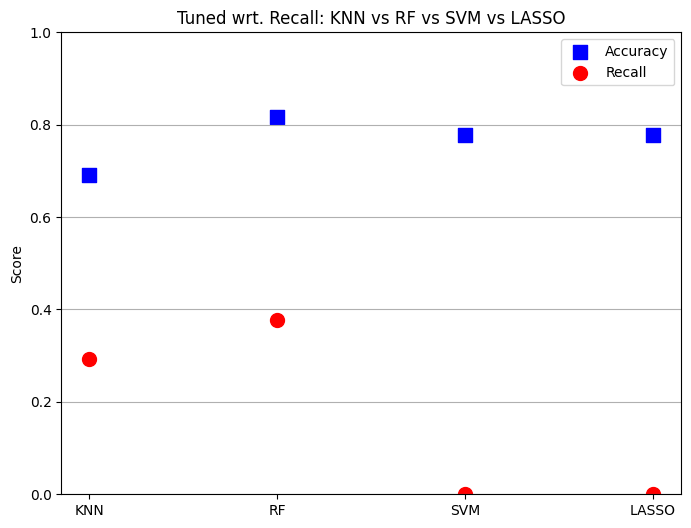

In [159]:

# Get accuracy score for the best recall (KNN)
rec_scores_knn = grid_knn_rec.cv_results_['mean_test_score'] #Taking the mean across folds
best_knn_rec = np.max(rec_scores_knn)
best_knn_rec_idx = np.argmax(rec_scores_knn)
acc_scores_knn = grid_knn_acc.cv_results_['mean_test_score'] #Taking the mean across folds
best_knn_acc_for_rec = acc_scores_knn[best_knn_rec_idx]

# Get accuracy score for the best recall (RF)
rec_scores_rf = grid_rf_rec.cv_results_['mean_test_score'] #Taking the mean across folds
best_rf_rec = np.max(rec_scores_rf)
best_rf_rec_idx = np.argmax(rec_scores_rf)
acc_scores_rf = grid_rf_acc.cv_results_['mean_test_score'] #Taking the mean across folds
best_rf_acc_for_rec = acc_scores_rf[best_rf_rec_idx]

# SVM
rec_scores_svm = grid_svm_rec.cv_results_['mean_test_score'] #Taking the mean across folds
best_svm_rec = np.max(rec_scores_svm)
best_svm_rec_idx = np.argmax(rec_scores_svm)
acc_scores_svm = grid_svm_acc.cv_results_['mean_test_score'] #Taking the mean across folds
best_svm_acc_for_rec = acc_scores_svm[best_svm_rec_idx]

# Get accuracy score for the best recall (LASSO)
rec_scores_lasso = lasso_rec.scores_[1].mean(axis=0) #Taking the mean across folds (All are 0)
best_lasso_rec = rec_scores_lasso.max()
best_lasso_rec_idx = np.argmax(rec_scores_lasso)
acc_scores_lasso = lasso.scores_[1].mean(axis=0) #Taking the mean across folds. Accrucacy does not change with different C values.
best_lasso_acc_for_rec = acc_scores_lasso[best_lasso_rec_idx]

#Comparison plot
models = ['KNN', 'RF', 'SVM', 'LASSO']
accuracy = [best_knn_acc_for_rec, best_rf_acc_for_rec, best_svm_acc_for_rec, best_lasso_acc_for_rec]
sensitivity = [best_knn_rec, best_rf_rec, best_svm_rec, best_lasso_rec]
x = np.arange(len(models))
print(accuracy)

plt.figure(figsize=(8, 6))
plt.scatter(x, accuracy, color='blue', label='Accuracy', marker='s', s=100)
plt.scatter(x, sensitivity, color='red', label='Recall', s=100)
plt.xticks(x, models)
plt.ylabel('Score')
plt.title('Tuned wrt. Recall: KNN vs RF vs SVM vs LASSO')
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')

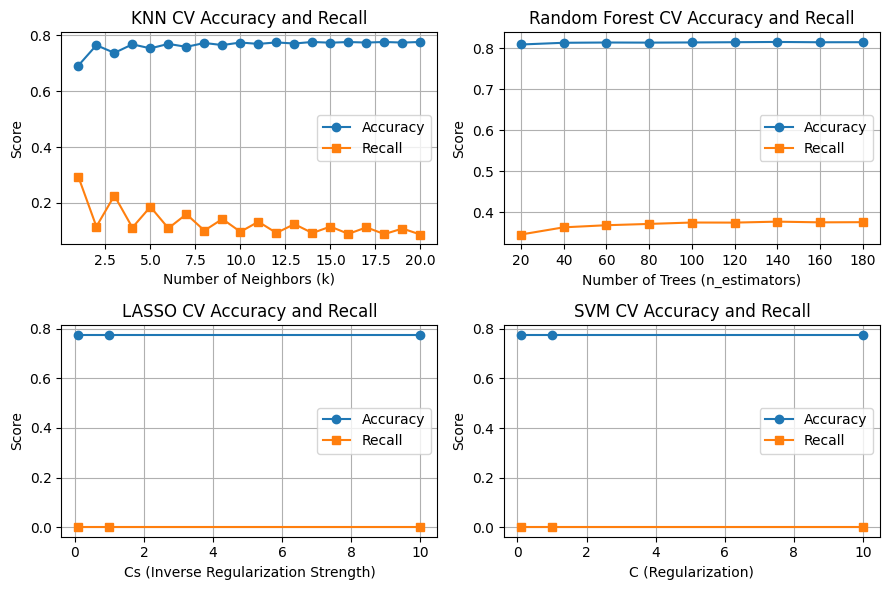

In [195]:
fig, axs = plt.subplots(2, 2, figsize=(9, 6))

# KNN plot
axs[0, 0].plot(k_values, acc_scores_knn, marker='o', label='Accuracy')
axs[0, 0].plot(k_values, rec_scores_knn, marker='s', label='Recall')
axs[0, 0].set_xlabel('Number of Neighbors (k)')
axs[0, 0].set_ylabel('Score')
axs[0, 0].set_title('KNN CV Accuracy and Recall')
axs[0, 0].legend()
axs[0, 0].grid(True)

# RF plot
axs[0, 1].plot(param_grid_rf['n_estimators'], acc_scores_rf, marker='o', label='Accuracy')
axs[0, 1].plot(param_grid_rf['n_estimators'], rec_scores_rf, marker='s', label='Recall')
axs[0, 1].set_xlabel('Number of Trees (n_estimators)')
axs[0, 1].set_ylabel('Score')
axs[0, 1].set_title('Random Forest CV Accuracy and Recall')
axs[0, 1].legend()
axs[0, 1].grid(True)

# LASSO plot
n_values_lasso = [0.1, 1, 10]
axs[1, 0].plot(n_values_lasso, acc_scores_lasso, marker='o', label='Accuracy')
axs[1, 0].plot(n_values_lasso, rec_scores_lasso, marker='s', label='Recall')
axs[1, 0].set_xlabel('Cs (Inverse Regularization Strength)')
axs[1, 0].set_ylabel('Score')
axs[1, 0].set_title('LASSO CV Accuracy and Recall')
axs[1, 0].legend()
axs[1, 0].grid(True)

# SVM plot
axs[1, 1].plot(param_grid_svm['C'], acc_scores_svm, marker='o', label='Accuracy')
axs[1, 1].plot(param_grid_svm['C'], rec_scores_svm, marker='s', label='Recall')
axs[1, 1].set_xlabel('C (Regularization)')
axs[1, 1].set_ylabel('Score')
axs[1, 1].set_title('SVM CV Accuracy and Recall')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Using SMOTE

I have searched around on the internet, and the common consensus is to only use SMOTE on the training data. So, I will follow that suggestion.

In [148]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(y_resampled.value_counts())  # Check the distribution of the resampled target variable

default payment next month
1    16324
0    16324
Name: count, dtype: int64


### KNN

In [149]:
# Grid search for best k using 5-fold CV
param_grid = {'n_neighbors': range(1, 21)}
knn_smt = KNeighborsClassifier()
k_values = param_grid['n_neighbors']

# GridSearchCV for accuracy
grid_knn_acc_smt = GridSearchCV(knn_smt, param_grid, cv=5, scoring='accuracy')
grid_knn_acc_smt.fit(X_resampled, y_resampled)

# GridSearchCV for sensitivity (recall)
grid_knn_rec_smt = GridSearchCV(knn_smt, param_grid, cv=5, scoring='recall')
grid_knn_rec_smt.fit(X_resampled, y_resampled)

# For confusion matrix
best_knn_smt = grid_knn_rec_smt.best_estimator_
print(best_knn_smt)

KNeighborsClassifier(n_neighbors=1)


In [150]:
# Define pipeline: SMOTE -> KNN
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

# Grid for KNN neighbors
param_grid = {
    'knn__n_neighbors': range(1, 21)  # note the prefix "knn__"
}

# GridSearchCV for accuracy
grid_knn_acc_smt = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='accuracy'
)
grid_knn_acc_smt.fit(X_train, y_train)

# GridSearchCV for recall (sensitivity)
grid_knn_rec_smt = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='recall'
)
grid_knn_rec_smt.fit(X_train, y_train)

# Best estimator (for confusion matrix, etc.)
best_knn_smt = grid_knn_rec_smt.best_estimator_
print(best_knn_smt)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('knn', KNeighborsClassifier(n_neighbors=19))])


### RF

In [188]:
pipeline_rf = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Parameter grid for RF
param_grid_rf = {
    'rf__n_estimators': range(20, 200, 20)  # note the "rf__" prefix
}


In [152]:

# GridSearchCV for accuracy
grid_rf_acc_smt = GridSearchCV(
    pipeline_rf, param_grid_rf, cv=5, scoring='accuracy'
)
grid_rf_acc_smt.fit(X_train, y_train)

# GridSearchCV for recall (sensitivity)
grid_rf_rec_smt = GridSearchCV(
    pipeline_rf, param_grid_rf, cv=5, scoring='recall'
)
grid_rf_rec_smt.fit(X_train, y_train)

# Best estimator (for confusion matrix, etc.)
best_rf_smt = grid_rf_rec_smt.best_estimator_

### SVM

In [187]:
pipeline_svm = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('svm', LinearSVC(random_state=42, max_iter=5000))
])

# Parameter grid (note the "svm__" prefix)
param_grid_svm = {
    'svm__C': [0.1, 1, 10]  # how much to penalize misclassifications
}


In [154]:

# GridSearchCV for accuracy
grid_svm_acc_smt = GridSearchCV(
    pipeline_svm,
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3
)
grid_svm_acc_smt.fit(X_train, y_train)

# GridSearchCV for recall (sensitivity)
grid_svm_rec_smt = GridSearchCV(
    pipeline_svm,
    param_grid_svm,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=3
)
grid_svm_rec_smt.fit(X_train, y_train)

# Best estimator (for confusion matrix, etc.)
best_svm_smt = grid_svm_rec_smt.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


### Regression

In [161]:
# Define pipeline: SMOTE -> Logistic Regression (LASSO)
pipeline_lasso = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('lasso', LogisticRegression(
        penalty='l1',
        solver='saga',
        max_iter=1000,
        random_state=42
    ))
])

# Hyperparameter grid for LASSO (C = inverse of regularization strength)
param_grid_lasso = {
    'lasso__C': [0.1, 1, 10]
}

# Accuracy optimization
grid_lasso_acc_smt = GridSearchCV(
    pipeline_lasso,
    param_grid_lasso,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_lasso_acc_smt.fit(X_train, y_train)

# Recall (sensitivity) optimization
grid_lasso_rec_smt = GridSearchCV(
    pipeline_lasso,
    param_grid_lasso,
    cv=5,
    scoring=make_scorer(recall_score),
    n_jobs=-1
)
grid_lasso_rec_smt.fit(X_train, y_train)

# Best estimator for confusion matrix
best_lasso_smt = grid_lasso_rec_smt.best_estimator_

c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Comparison of the models

[0.5785238095238097, 0.7857142857142858, 0.5674761904761905, 0.6833333333333333]


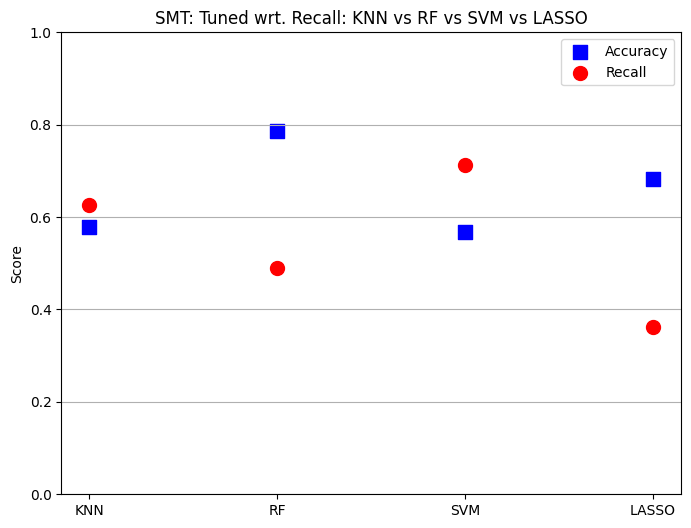

In [196]:
# Get accuracy score for the best recall (KNN)
rec_scores_knn_smt = grid_knn_rec_smt.cv_results_['mean_test_score'] #Taking the mean across folds
best_knn_rec_smt = np.max(rec_scores_knn_smt)
best_knn_rec_idx_smt = np.argmax(rec_scores_knn_smt)
acc_scores_knn_smt = grid_knn_acc_smt.cv_results_['mean_test_score'] #Taking the mean across folds
best_knn_acc_for_rec_smt = acc_scores_knn_smt[best_knn_rec_idx_smt]

# Get accuracy score for the best recall (RF)
rec_scores_rf_smt = grid_rf_rec_smt.cv_results_['mean_test_score'] #Taking the mean across folds
best_rf_rec_smt = np.max(rec_scores_rf_smt)
best_rf_rec_idx_smt = np.argmax(rec_scores_rf_smt)
acc_scores_rf_smt = grid_rf_acc_smt.cv_results_['mean_test_score'] #Taking the mean across folds
best_rf_acc_for_rec_smt = acc_scores_rf_smt[best_rf_rec_idx_smt]

# SVM
rec_scores_svm_smt = grid_svm_rec_smt.cv_results_['mean_test_score'] #Taking the mean across folds
best_svm_rec_smt = np.max(rec_scores_svm_smt)
best_svm_rec_idx_smt = np.argmax(rec_scores_svm_smt)
acc_scores_svm_smt = grid_svm_acc_smt.cv_results_['mean_test_score'] #Taking the mean across folds
best_svm_acc_for_rec_smt = acc_scores_svm_smt[best_svm_rec_idx_smt]

# Get accuracy score for the best recall (LASSO)
rec_scores_lasso_smt = grid_lasso_rec_smt.cv_results_['mean_test_score']
best_lasso_rec_smt = rec_scores_lasso_smt.max()
best_lasso_rec_idx_smt = rec_scores_lasso_smt.argmax()

# Accuracy of the best recall model
acc_scores_lasso_smt = grid_lasso_acc_smt.cv_results_['mean_test_score']
best_lasso_acc_for_rec_smt = acc_scores_lasso_smt[best_lasso_rec_idx_smt]

# Comparison plot
models_smt = ['KNN', 'RF', 'SVM', 'LASSO']
accuracy_smt = [best_knn_acc_for_rec_smt, best_rf_acc_for_rec_smt, best_svm_acc_for_rec_smt, best_lasso_acc_for_rec_smt]
sensitivity_smt = [best_knn_rec_smt, best_rf_rec_smt, best_svm_rec_smt, best_lasso_rec_smt]
x_smt = np.arange(len(models_smt))
print(accuracy_smt)

plt.figure(figsize=(8, 6))
plt.scatter(x_smt, accuracy_smt, color='blue', marker='s', label='Accuracy', s=100)
plt.scatter(x_smt, sensitivity_smt, color='red', label='Recall', s=100)
plt.xticks(x_smt, models_smt)
plt.ylabel('Score')
plt.title('SMT: Tuned wrt. Recall: KNN vs RF vs SVM vs LASSO')
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')


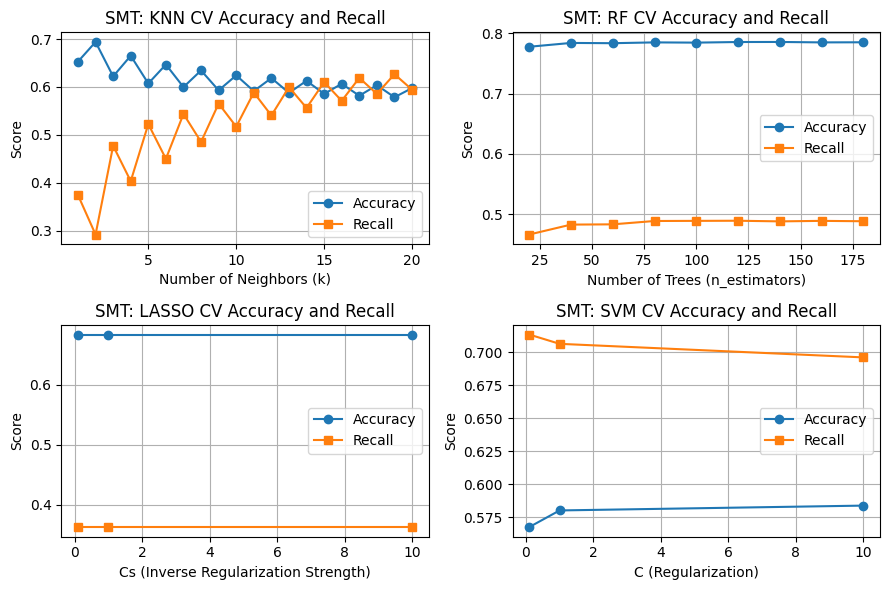

In [189]:
fig_smt, axs_smt = plt.subplots(2, 2, figsize=(9, 6))

# KNN plot
axs_smt[0, 0].plot(k_values, acc_scores_knn_smt, marker='o', label='Accuracy')
axs_smt[0, 0].plot(k_values, rec_scores_knn_smt, marker='s', label='Recall')
axs_smt[0, 0].set_xlabel('Number of Neighbors (k)')
axs_smt[0, 0].set_ylabel('Score')
axs_smt[0, 0].set_title('SMT: KNN CV Accuracy and Recall')
axs_smt[0, 0].legend()
axs_smt[0, 0].grid(True)

# RF plot
axs_smt[0, 1].plot(param_grid_rf['rf__n_estimators'], acc_scores_rf_smt, marker='o', label='Accuracy')
axs_smt[0, 1].plot(param_grid_rf['rf__n_estimators'], rec_scores_rf_smt, marker='s', label='Recall')
axs_smt[0, 1].set_xlabel('Number of Trees (n_estimators)')
axs_smt[0, 1].set_ylabel('Score')
axs_smt[0, 1].set_title('SMT: RF CV Accuracy and Recall')
axs_smt[0, 1].legend()
axs_smt[0, 1].grid(True)

# LASSO plot
n_values_lasso_smt = [0.1, 1, 10]
axs_smt[1, 0].plot(n_values_lasso_smt, acc_scores_lasso_smt, marker='o', label='Accuracy')
axs_smt[1, 0].plot(n_values_lasso_smt, rec_scores_lasso_smt, marker='s', label='Recall')
axs_smt[1, 0].set_xlabel('Cs (Inverse Regularization Strength)')
axs_smt[1, 0].set_ylabel('Score')
axs_smt[1, 0].set_title('SMT: LASSO CV Accuracy and Recall')
axs_smt[1, 0].legend()
axs_smt[1, 0].grid(True)

# SVM plot
axs_smt[1, 1].plot(param_grid_svm['svm__C'], acc_scores_svm_smt, marker='o', label='Accuracy')
axs_smt[1, 1].plot(param_grid_svm['svm__C'], rec_scores_svm_smt, marker='s', label='Recall')
axs_smt[1, 1].set_xlabel('C (Regularization)')
axs_smt[1, 1].set_ylabel('Score')
axs_smt[1, 1].set_title('SMT: SVM CV Accuracy and Recall')
axs_smt[1, 1].legend()
axs_smt[1, 1].grid(True)

plt.tight_layout()


# Using PCA

In [69]:
### DATA
df_gen = train.iloc[:, 1:6]
df_pay = train.iloc[:, 7:12]
df_bill = train.iloc[:, 13:18]
df_pay_amt = train.iloc[:, 19:24]

# --- PCA for pay ---
scaler_pay = StandardScaler()
df_pay_scaled = scaler_pay.fit_transform(df_pay)
pca_pay = PCA()
df_pay_pca = pca_pay.fit_transform(df_pay_scaled)
df_pay_first = pd.DataFrame(df_pay_pca[:, [0]], columns=["PAY_PCA1"])

# --- PCA for bill ---
scaler_bill = StandardScaler()
df_bill_scaled = scaler_bill.fit_transform(df_bill)
pca_bill = PCA()
df_bill_pca = pca_bill.fit_transform(df_bill_scaled)
df_bill_first = pd.DataFrame(df_bill_pca[:, [0]], columns=["BILL_PCA1"])

# --- concatenate all parts into DataFrame ---
df_PCA_X = pd.concat(
    [df_gen.reset_index(drop=True),
     df_pay_first.reset_index(drop=True),
     df_bill_first.reset_index(drop=True),
     df_pay_amt.reset_index(drop=True)], 
    axis=1
)

print(df_PCA_X.head())

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_PCA1  BILL_PCA1  PAY_AMT2  \
0     240000    2          1         1   40 -3.406897  -1.504030         0   
1      50000    2          1         2   23 -1.496615  -1.361414      2321   
2      50000    2          2         1   36  2.666477   0.022715      4700   
3     200000    2          3         1   54  6.439848   1.326729         0   
4     240000    1          1         1   35 -1.098790  -0.959993     21817   

   PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
0         0         0         0         0  
1      4800      9810       660      2980  
2         0      2004      3500         0  
3         0         0         0         0  
4      1120     13434     22772     22820  


### KNN

In [60]:
# Grid search for best k using 5-fold CV
# Grid search for best k using 5-fold CV
param_grid = {'n_neighbors': range(1, 21)}
knn_pca = KNeighborsClassifier()
k_values = param_grid['n_neighbors']

# GridSearchCV for accuracy
grid_knn_acc_pca = GridSearchCV(knn_pca, param_grid, cv=5, scoring='accuracy')
grid_knn_acc_pca.fit(df_PCA_X, y_train)

# GridSearchCV for sensitivity (recall)
grid_knn_rec_pca = GridSearchCV(knn_pca, param_grid, cv=5, scoring='recall')
grid_knn_rec_pca.fit(df_PCA_X, y_train)

# For confusion matrix
best_knn_pca = grid_knn_rec_pca.best_estimator_

### RF

In [193]:
# Initialize RandomForestClassifier and define parameter grid
param_grid_rf = {'n_estimators': range(20, 200, 20)}
rf_pca = RandomForestClassifier(random_state=42)
n_values = param_grid_rf['n_estimators']


In [ ]:

# GridSearchCV for accuracy
grid_rf_acc_pca = GridSearchCV(rf_pca, param_grid_rf, cv=5, scoring='accuracy')
grid_rf_acc_pca.fit(df_PCA_X, y_train)

# GridSearchCV for sensitivity (recall)
grid_rf_rec_pca = GridSearchCV(rf_pca, param_grid_rf, cv=5, scoring='recall')
grid_rf_rec_pca.fit(df_PCA_X, y_train)

# For confusion matrix
best_rf_pca = grid_rf_rec_pca.best_estimator_

### SVM

In [194]:
param_grid_svm = {'C': [0.1, 1, 10]} #Descibes how much to penalize misclassifications. High C means low regularization (penalization).
svm_pca = LinearSVC(random_state=42, max_iter=5000)
n_values = param_grid_svm['C']


In [ ]:

# GridSearchCV for accuracy
grid_svm_acc_pca = GridSearchCV(
    svm_pca,
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,   # use all CPU cores
    verbose=3    # progress output
)

# Running the grid search
grid_svm_acc_pca.fit(df_PCA_X, y_train)


# GridSearchCV for sensitivity (recall)
grid_svm_rec_pca = GridSearchCV(
    svm_pca,
    param_grid_svm,
    cv=5,
    scoring='recall',
    n_jobs=-1,   # use all CPU cores
    verbose=3    # progress output
)

# Running the grid search
grid_svm_rec_pca.fit(df_PCA_X, y_train)


best_svm_pca = grid_svm_rec_pca.best_estimator_

### Regression

In [63]:
#### Linear regression with LASSO regularization
n_values_lasso = [0.1, 1, 10]

# LASSO logistic regression (L1 penalty)
lasso_pca = LogisticRegressionCV(
    Cs=n_values_lasso, cv=5, penalty='l1', solver='saga', scoring='accuracy', max_iter=1000, random_state=42
)
lasso_pca.fit(df_PCA_X, y_train)

# Sensitivity (recall) for LASSO
lasso_rec_pca = LogisticRegressionCV(
    Cs=n_values_lasso, cv=5, penalty='l1', solver='saga', scoring=make_scorer(recall_score), max_iter=1000, random_state=42
)
lasso_rec_pca.fit(df_PCA_X, y_train)

c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means

,Cs,"[0.1, 1, ...]"
,fit_intercept,True
,cv,5
,dual,False
,penalty,'l1'
,scoring,make_scorer(r...hod='predict')
,solver,'saga'
,tol,0.0001
,max_iter,1000
,class_weight,None
,n_jobs,None


## Comparing the different models

[0.6909523809523808, 0.7969999999999999, 0.7774761904761904, 0.7773333333333332]


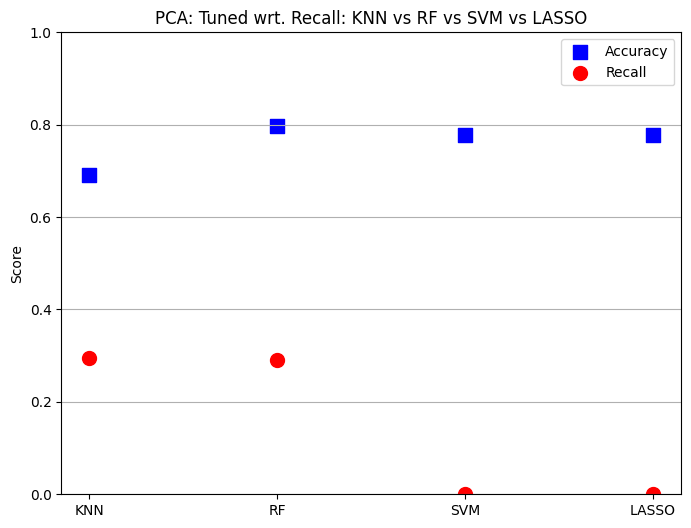

In [197]:
# Get accuracy score for the best recall (KNN)
rec_scores_knn_pca = grid_knn_rec_pca.cv_results_['mean_test_score'] #Taking the mean across folds
best_knn_rec_pca = np.max(rec_scores_knn_pca)
best_knn_rec_idx_pca = np.argmax(rec_scores_knn_pca)
acc_scores_knn_pca = grid_knn_acc_pca.cv_results_['mean_test_score'] #Taking the mean across folds
best_knn_acc_for_rec_pca = acc_scores_knn_pca[best_knn_rec_idx_pca]

# Get accuracy score for the best recall (RF)
rec_scores_rf_pca = grid_rf_rec_pca.cv_results_['mean_test_score'] #Taking the mean across folds
best_rf_rec_pca = np.max(rec_scores_rf_pca)
best_rf_rec_idx_pca = np.argmax(rec_scores_rf_pca)
acc_scores_rf_pca = grid_rf_acc_pca.cv_results_['mean_test_score'] #Taking the mean across folds
best_rf_acc_for_rec_pca = acc_scores_rf_pca[best_rf_rec_idx_pca]

# SVM
rec_scores_svm_pca = grid_svm_rec_pca.cv_results_['mean_test_score'] #Taking the mean across folds
best_svm_rec_pca = np.max(rec_scores_svm_pca)
best_svm_rec_idx_pca = np.argmax(rec_scores_svm_pca)
acc_scores_svm_pca = grid_svm_acc_pca.cv_results_['mean_test_score'] #Taking the mean across folds
best_svm_acc_for_rec_pca = acc_scores_svm_pca[best_svm_rec_idx_pca]

# Get accuracy score for the best recall (LASSO)
rec_scores_lasso_pca = lasso_rec_pca.scores_[1].mean(axis=0) #Taking the mean across folds (All are 0)
best_lasso_rec_pca = rec_scores_lasso_pca.max()
best_lasso_rec_idx_pca = np.argmax(rec_scores_lasso_pca)
acc_scores_lasso_pca = lasso_pca.scores_[1].mean(axis=0) #Taking the mean across folds. Accuracy does not change with different C values.
best_lasso_acc_for_rec_pca = acc_scores_lasso_pca[best_lasso_rec_idx_pca]

# Comparison plot
models_pca = ['KNN', 'RF', 'SVM', 'LASSO']
accuracy_pca = [best_knn_acc_for_rec_pca, best_rf_acc_for_rec_pca, best_svm_acc_for_rec_pca, best_lasso_acc_for_rec_pca]
sensitivity_pca = [best_knn_rec_pca, best_rf_rec_pca, best_svm_rec_pca, best_lasso_rec_pca]
x_pca = np.arange(len(models_pca))
print(accuracy_pca)

plt.figure(figsize=(8, 6))
plt.scatter(x_pca, accuracy_pca, color='blue', label='Accuracy', marker='s', s=100)
plt.scatter(x_pca, sensitivity_pca, color='red', label='Recall', s=100)
plt.xticks(x_pca, models_pca)
plt.ylabel('Score')
plt.title('PCA: Tuned wrt. Recall: KNN vs RF vs SVM vs LASSO')
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')

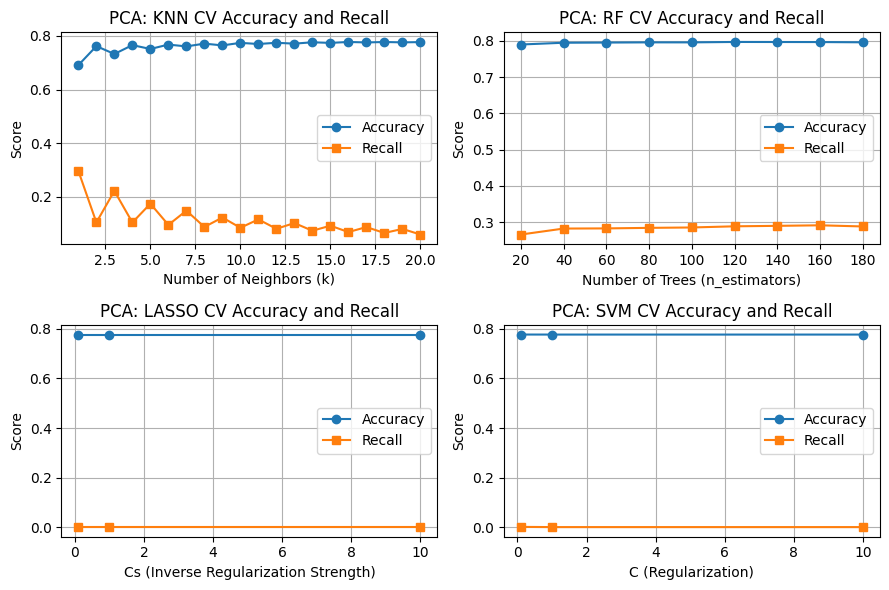

In [185]:
fig_pca, axs_pca = plt.subplots(2, 2, figsize=(9, 6))

# KNN plot
axs_pca[0, 0].plot(k_values, acc_scores_knn_pca, marker='o', label='Accuracy')
axs_pca[0, 0].plot(k_values, rec_scores_knn_pca, marker='s', label='Recall')
axs_pca[0, 0].set_xlabel('Number of Neighbors (k)')
axs_pca[0, 0].set_ylabel('Score')
axs_pca[0, 0].set_title('PCA: KNN CV Accuracy and Recall')
axs_pca[0, 0].legend()
axs_pca[0, 0].grid(True)

# RF plot
axs_pca[0, 1].plot(param_grid_rf['n_estimators'], acc_scores_rf_pca, marker='o', label='Accuracy')
axs_pca[0, 1].plot(param_grid_rf['n_estimators'], rec_scores_rf_pca, marker='s', label='Recall')
axs_pca[0, 1].set_xlabel('Number of Trees (n_estimators)')
axs_pca[0, 1].set_ylabel('Score')
axs_pca[0, 1].set_title('PCA: RF CV Accuracy and Recall')
axs_pca[0, 1].legend()
axs_pca[0, 1].grid(True)

# LASSO plot
n_values_lasso_pca = [0.1, 1, 10]
axs_pca[1, 0].plot(n_values_lasso_pca, acc_scores_lasso_pca, marker='o', label='Accuracy')
axs_pca[1, 0].plot(n_values_lasso_pca, rec_scores_lasso_pca, marker='s', label='Recall')
axs_pca[1, 0].set_xlabel('Cs (Inverse Regularization Strength)')
axs_pca[1, 0].set_ylabel('Score')
axs_pca[1, 0].set_title('PCA: LASSO CV Accuracy and Recall')
axs_pca[1, 0].legend()
axs_pca[1, 0].grid(True)

# SVM plot
axs_pca[1, 1].plot(param_grid_svm['C'], acc_scores_svm_pca, marker='o', label='Accuracy')
axs_pca[1, 1].plot(param_grid_svm['C'], rec_scores_svm_pca, marker='s', label='Recall')
axs_pca[1, 1].set_xlabel('C (Regularization)')
axs_pca[1, 1].set_ylabel('Score')
axs_pca[1, 1].set_title('PCA: SVM CV Accuracy and Recall')
axs_pca[1, 1].legend()
axs_pca[1, 1].grid(True)

plt.tight_layout()


# PCA + SMOTE

In [73]:
smote = SMOTE(random_state=42)

X_resampled_pca, y_resampled_pca = smote.fit_resample(df_PCA_X, y_train)

### KNN

In [74]:
# Grid search for best k using 5-fold CV
param_grid = {'n_neighbors': range(1, 21)}
knn_smt_pca = KNeighborsClassifier()
k_values = param_grid['n_neighbors']

# GridSearchCV for accuracy
grid_knn_acc_smt_pca = GridSearchCV(knn_smt_pca, param_grid, cv=5, scoring='accuracy')
grid_knn_acc_smt_pca.fit(X_resampled_pca, y_resampled_pca)

# GridSearchCV for sensitivity (recall)
grid_knn_rec_smt_pca = GridSearchCV(knn_smt_pca, param_grid, cv=5, scoring='recall')
grid_knn_rec_smt_pca.fit(X_resampled_pca, y_resampled_pca)

# For confusion matrix
best_knn_smt_pca = grid_knn_rec_smt_pca.best_estimator_

### RF

In [75]:
# Initialize RandomForestClassifier and define parameter grid
param_grid_rf = {'n_estimators': range(20, 200, 20)}
rf_smt_pca = RandomForestClassifier(random_state=42)
n_values = param_grid_rf['n_estimators']

# GridSearchCV for accuracy
grid_rf_acc_smt_pca = GridSearchCV(rf_smt_pca, param_grid_rf, cv=5, scoring='accuracy')
grid_rf_acc_smt_pca.fit(X_resampled_pca, y_resampled_pca)

# GridSearchCV for sensitivity (recall)
grid_rf_rec_smt_pca = GridSearchCV(rf_smt_pca, param_grid_rf, cv=5, scoring='recall')
grid_rf_rec_smt_pca.fit(X_resampled_pca, y_resampled_pca)

# For confusion matrix
best_rf_smt_pca = grid_rf_rec_smt_pca.best_estimator_

### SVM

In [76]:
param_grid_svm = {'C': [0.1, 1, 10]} #Descibes how much to penalize misclassifications. High C means low regularization (penalization).
svm_smt_pca = LinearSVC(random_state=42, max_iter=5000)
n_values = param_grid_svm['C']

# GridSearchCV for accuracy
grid_svm_acc_smt_pca = GridSearchCV(
    svm_smt_pca,
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,   # use all CPU cores
    verbose=3    # progress output
)

# Running the grid search
grid_svm_acc_smt_pca.fit(X_resampled_pca, y_resampled_pca)


# GridSearchCV for sensitivity (recall)
grid_svm_rec_smt_pca = GridSearchCV(
    svm_smt_pca,
    param_grid_svm,
    cv=5,
    scoring='recall',
    n_jobs=-1,   # use all CPU cores
    verbose=3    # progress output
)

# Running the grid search
grid_svm_rec_smt_pca.fit(X_resampled_pca, y_resampled_pca)


best_svm_smt_pca = grid_svm_rec_smt_pca.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


### Regression

In [77]:
#### Linear regression with LASSO regularization
n_values_lasso = [0.1, 1, 10]

# LASSO logistic regression (L1 penalty)
lasso_smt_pca = LogisticRegressionCV(
    Cs=n_values_lasso, cv=5, penalty='l1', solver='saga', scoring='accuracy', max_iter=1000, random_state=42
)
lasso_smt_pca.fit(X_resampled_pca, y_resampled_pca)

# Sensitivity (recall) for LASSO
lasso_rec_smt_pca = LogisticRegressionCV(
    Cs=n_values_lasso, cv=5, penalty='l1', solver='saga', scoring=make_scorer(recall_score), max_iter=1000, random_state=42
)
lasso_rec_smt_pca.fit(X_resampled_pca, y_resampled_pca)

c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cns486\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means

,Cs,"[0.1, 1, ...]"
,fit_intercept,True
,cv,5
,dual,False
,penalty,'l1'
,scoring,make_scorer(r...hod='predict')
,solver,'saga'
,tol,0.0001
,max_iter,1000
,class_weight,None
,n_jobs,None


## Comparing the models

[0.8045516985474395, 0.8224726435502625, 0.6033141101885638, 0.5]


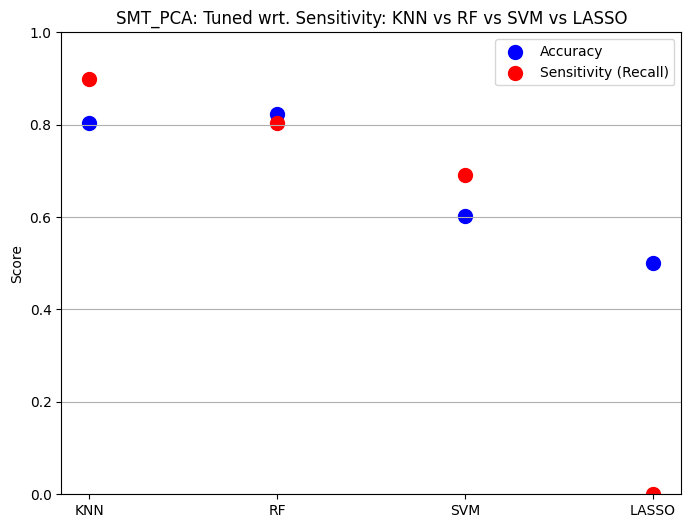

In [ ]:
# Get accuracy score for the best recall (KNN)
rec_scores_knn_smt_pca = grid_knn_rec_smt_pca.cv_results_['mean_test_score']  # Taking the mean across folds
best_knn_rec_smt_pca = np.max(rec_scores_knn_smt_pca)
best_knn_rec_idx_smt_pca = np.argmax(rec_scores_knn_smt_pca)
acc_scores_knn_smt_pca = grid_knn_acc_smt_pca.cv_results_['mean_test_score']  # Taking the mean across folds
best_knn_acc_for_rec_smt_pca = acc_scores_knn_smt_pca[best_knn_rec_idx_smt_pca]

# Get accuracy score for the best recall (RF)
rec_scores_rf_smt_pca = grid_rf_rec_smt_pca.cv_results_['mean_test_score']  # Taking the mean across folds
best_rf_rec_smt_pca = np.max(rec_scores_rf_smt_pca)
best_rf_rec_idx_smt_pca = np.argmax(rec_scores_rf_smt_pca)
acc_scores_rf_smt_pca = grid_rf_acc_smt_pca.cv_results_['mean_test_score']  # Taking the mean across folds
best_rf_acc_for_rec_smt_pca = acc_scores_rf_smt_pca[best_rf_rec_idx_smt_pca]

# SVM
rec_scores_svm_smt_pca = grid_svm_rec_smt_pca.cv_results_['mean_test_score']  # Taking the mean across folds
best_svm_rec_smt_pca = np.max(rec_scores_svm_smt_pca)
best_svm_rec_idx_smt_pca = np.argmax(rec_scores_svm_smt_pca)
acc_scores_svm_smt_pca = grid_svm_acc_smt_pca.cv_results_['mean_test_score']  # Taking the mean across folds
best_svm_acc_for_rec_smt_pca = acc_scores_svm_smt_pca[best_svm_rec_idx_smt_pca]

# Get accuracy score for the best recall (LASSO)
rec_scores_lasso_smt_pca = lasso_rec_smt_pca.scores_[1].mean(axis=0)  # Taking the mean across folds
best_lasso_rec_smt_pca = rec_scores_lasso_smt_pca.max()
best_lasso_rec_idx_smt_pca = np.argmax(rec_scores_lasso_smt_pca)
acc_scores_lasso_smt_pca = lasso_smt_pca.scores_[1].mean(axis=0)  # Accuracy does not change with different C values
best_lasso_acc_for_rec_smt_pca = acc_scores_lasso_smt_pca[best_lasso_rec_idx_smt_pca]

# Comparison plot
models_smt_pca = ['KNN', 'RF', 'SVM', 'LASSO']
accuracy_smt_pca = [best_knn_acc_for_rec_smt_pca, best_rf_acc_for_rec_smt_pca, best_svm_acc_for_rec_smt_pca, best_lasso_acc_for_rec_smt_pca]
sensitivity_smt_pca = [best_knn_rec_smt_pca, best_rf_rec_smt_pca, best_svm_rec_smt_pca, best_lasso_rec_smt_pca]
x_smt_pca = np.arange(len(models_smt_pca))
print(accuracy_smt_pca)

plt.figure(figsize=(8, 6))
plt.scatter(x_smt_pca, accuracy_smt_pca, color='blue', label='Accuracy', s=100)
plt.scatter(x_smt_pca, sensitivity_smt_pca, color='red', label='Sensitivity (Recall)', s=100)
plt.xticks(x_smt_pca, models_smt_pca)
plt.ylabel('Score')
plt.title('SMT_PCA: Tuned wrt. Sensitivity: KNN vs RF vs SVM vs LASSO')
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')


KeyError: 'n_estimators'

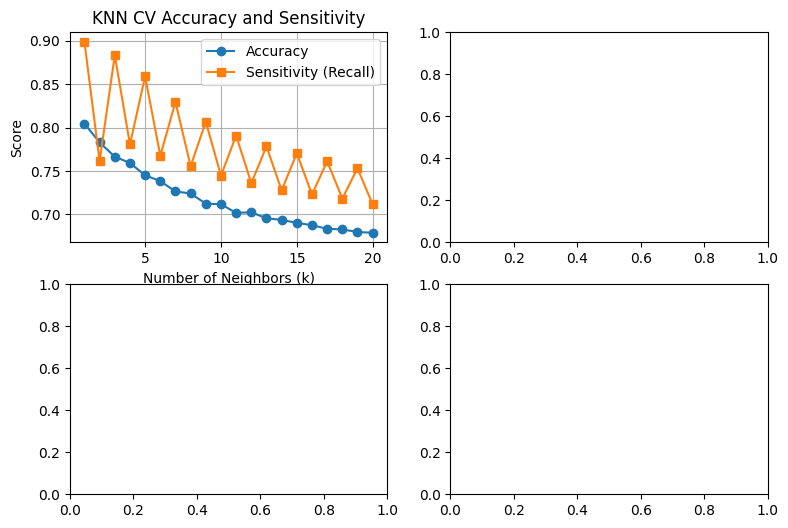

In [102]:
fig_smt_pca, axs_smt_pca = plt.subplots(2, 2, figsize=(9, 6))

# KNN plot
axs_smt_pca[0, 0].plot(k_values, acc_scores_knn_smt_pca, marker='o', label='Accuracy')
axs_smt_pca[0, 0].plot(k_values, rec_scores_knn_smt_pca, marker='s', label='Sensitivity (Recall)')
axs_smt_pca[0, 0].set_xlabel('Number of Neighbors (k)')
axs_smt_pca[0, 0].set_ylabel('Score')
axs_smt_pca[0, 0].set_title('KNN CV Accuracy and Sensitivity')
axs_smt_pca[0, 0].legend()
axs_smt_pca[0, 0].grid(True)

# RF plot
axs_smt_pca[0, 1].plot(param_grid_rf['n_estimators'], acc_scores_rf_smt_pca, marker='o', label='Accuracy')
axs_smt_pca[0, 1].plot(param_grid_rf['n_estimators'], rec_scores_rf_smt_pca, marker='s', label='Sensitivity (Recall)')
axs_smt_pca[0, 1].set_xlabel('Number of Trees (n_estimators)')
axs_smt_pca[0, 1].set_ylabel('Score')
axs_smt_pca[0, 1].set_title('Random Forest CV Accuracy and Sensitivity')
axs_smt_pca[0, 1].legend()
axs_smt_pca[0, 1].grid(True)

# LASSO plot
n_values_lasso_smt_pca = [0.1, 1, 10]
axs_smt_pca[1, 0].plot(n_values_lasso_smt_pca, acc_scores_lasso_smt_pca, marker='o', label='Accuracy')
axs_smt_pca[1, 0].plot(n_values_lasso_smt_pca, rec_scores_lasso_smt_pca, marker='s', label='Sensitivity (Recall)')
axs_smt_pca[1, 0].set_xlabel('Cs (Inverse Regularization Strength)')
axs_smt_pca[1, 0].set_ylabel('Score')
axs_smt_pca[1, 0].set_title('LASSO CV Accuracy and Sensitivity')
axs_smt_pca[1, 0].legend()
axs_smt_pca[1, 0].grid(True)

# SVM plot
axs_smt_pca[1, 1].plot(param_grid_svm['C'], acc_scores_svm_smt_pca, marker='o', label='Accuracy')
axs_smt_pca[1, 1].plot(param_grid_svm['C'], rec_scores_svm_smt_pca, marker='s', label='Sensitivity (Recall)')
axs_smt_pca[1, 1].set_xlabel('C (Regularization)')
axs_smt_pca[1, 1].set_ylabel('Score')
axs_smt_pca[1, 1].set_title('PCA+SMT: SVM CV Accuracy and Sensitivity')
axs_smt_pca[1, 1].legend()
axs_smt_pca[1, 1].grid(True)

plt.tight_layout()


# Evaluation the model on validation data

In [164]:
#Validation data
X_val = val.iloc[:, 1:-1]
y_val = val.iloc[:, -1]

#PCA Validation data
df_gen_val = val.iloc[:, 1:6]
df_pay_val = val.iloc[:, 7:12]
df_bill_val = val.iloc[:, 13:18]
df_pay_amt_val = val.iloc[:, 19:24]

# --- PCA for pay ---
df_pay_scaled_val = scaler_pay.transform(df_pay_val)
df_pay_pca_val = pca_pay.transform(df_pay_scaled_val)
df_pay_first_val = pd.DataFrame(df_pay_pca_val[:, [0]], columns=["PAY_PCA1"])

# --- PCA for bill ---
df_bill_scaled_val = scaler_bill.transform(df_bill_val)
df_bill_pca_val = pca_bill.transform(df_bill_scaled_val)
df_bill_first_val = pd.DataFrame(df_bill_pca_val[:, [0]], columns=["BILL_PCA1"])

# --- concatenate all parts into DataFrame ---
df_PCA_X_val = pd.concat(
    [df_gen_val.reset_index(drop=True),
     df_pay_first_val.reset_index(drop=True),
     df_bill_first_val.reset_index(drop=True),
     df_pay_amt_val.reset_index(drop=True)], 
    axis=1
)

print(y_val.value_counts())


default payment next month
0    3535
1     965
Name: count, dtype: int64


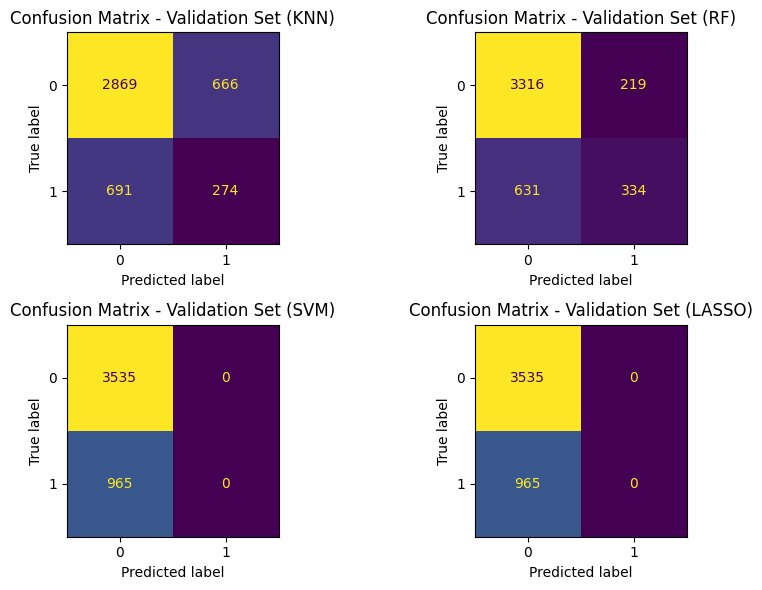

In [165]:
# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(9, 6))

# --- KNN ---
y_val_pred = best_knn.predict(X_val)
cm_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(ax=axes[0, 0], colorbar=False)
axes[0, 0].set_title('Confusion Matrix - Validation Set (KNN)')

# --- RF ---
y_val_pred_rf = best_rf.predict(X_val)
cm_val_rf = confusion_matrix(y_val, y_val_pred_rf)
disp_val_rf = ConfusionMatrixDisplay(confusion_matrix=cm_val_rf)
disp_val_rf.plot(ax=axes[0, 1], colorbar=False)
axes[0, 1].set_title('Confusion Matrix - Validation Set (RF)')

# --- SVM ---
y_val_pred_svm = best_svm.predict(X_val)
cm_val_svm = confusion_matrix(y_val, y_val_pred_svm)
disp_val_svm = ConfusionMatrixDisplay(confusion_matrix=cm_val_svm)
disp_val_svm.plot(ax=axes[1, 0], colorbar=False)
axes[1, 0].set_title('Confusion Matrix - Validation Set (SVM)')

# --- LASSO ---
y_val_pred_lasso = lasso_rec.predict(X_val) #Should chose the C which maximizes recall. Below is the C value used. Check it if in doubt
#print(lasso.C_)
cm_val_lasso = confusion_matrix(y_val, y_val_pred_lasso)
disp_val_lasso = ConfusionMatrixDisplay(confusion_matrix=cm_val_lasso)
disp_val_lasso.plot(ax=axes[1, 1], colorbar=False)
axes[1, 1].set_title('Confusion Matrix - Validation Set (LASSO)')

# Adjust layout
plt.tight_layout()
plt.show()


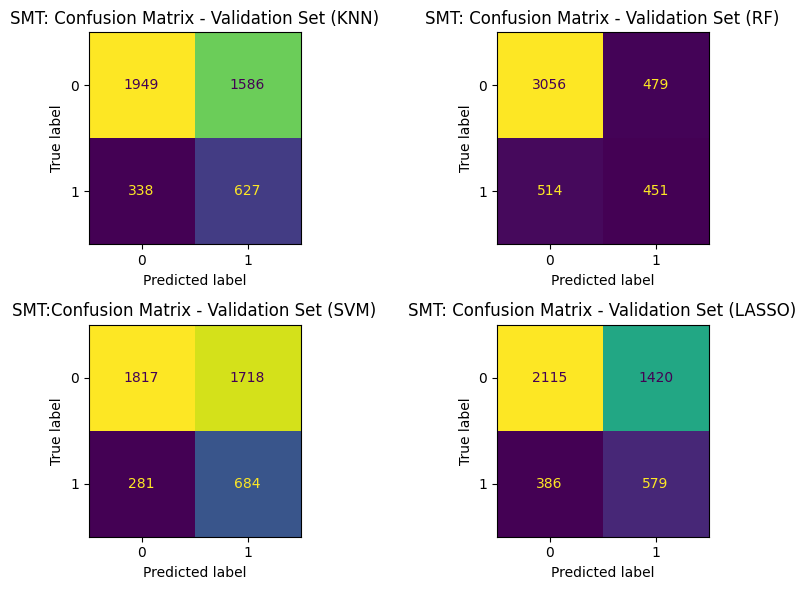

In [100]:
fig, axes = plt.subplots(2, 2, figsize=(9, 6))

# Using SMOTE models
# --- KNN ---
y_val_pred_smt = best_knn_smt.predict(X_val)
cm_val = confusion_matrix(y_val, y_val_pred_smt)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(ax=axes[0, 0], colorbar=False)
axes[0, 0].set_title('SMT: Confusion Matrix - Validation Set (KNN)')

# --- RF ---
y_val_pred_rf_smt = best_rf_smt.predict(X_val)
cm_val_rf = confusion_matrix(y_val, y_val_pred_rf_smt)
disp_val_rf = ConfusionMatrixDisplay(confusion_matrix=cm_val_rf)
disp_val_rf.plot(ax=axes[0, 1], colorbar=False)
axes[0, 1].set_title('SMT: Confusion Matrix - Validation Set (RF)')

# --- SVM ---
y_val_pred_svm_smt = best_svm_smt.predict(X_val)
cm_val_svm = confusion_matrix(y_val, y_val_pred_svm_smt)
disp_val_svm = ConfusionMatrixDisplay(confusion_matrix=cm_val_svm)
disp_val_svm.plot(ax=axes[1, 0], colorbar=False)
axes[1, 0].set_title('SMT:Confusion Matrix - Validation Set (SVM)')

# --- LASSO ---
y_val_pred_lasso_smt = lasso_rec_smt.predict(X_val) #Should chose the C which maximizes recall. Below is the C value used. Check it if in doubt
#print(lasso.C_)
cm_val_lasso = confusion_matrix(y_val, y_val_pred_lasso_smt)
disp_val_lasso = ConfusionMatrixDisplay(confusion_matrix=cm_val_lasso)
disp_val_lasso.plot(ax=axes[1, 1], colorbar=False)
axes[1, 1].set_title('SMT: Confusion Matrix - Validation Set (LASSO)')

# Adjust layout
plt.tight_layout()
plt.show()


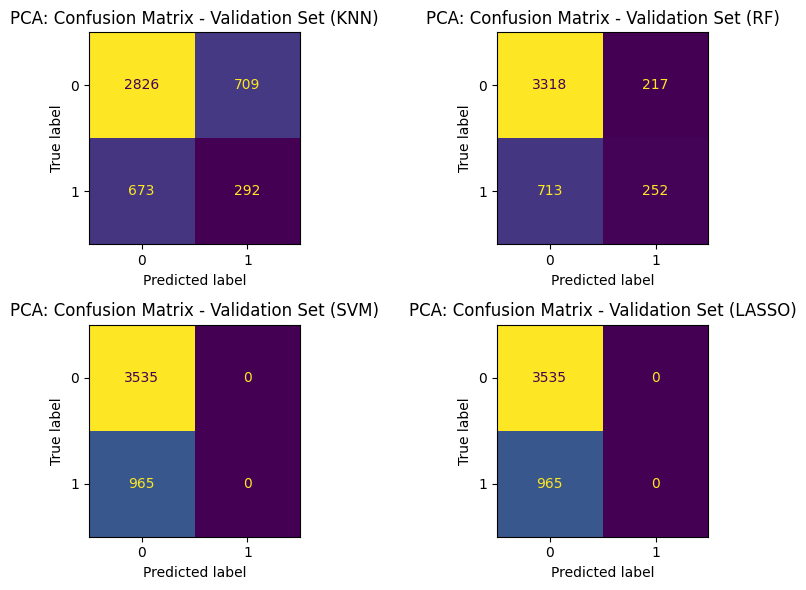

In [101]:
fig, axes = plt.subplots(2, 2, figsize=(9, 6))

# Using SMOTE models
# --- KNN ---
y_val_pred_pca = best_knn_pca.predict(df_PCA_X_val)
cm_val = confusion_matrix(y_val, y_val_pred_pca)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(ax=axes[0, 0], colorbar=False)
axes[0, 0].set_title('PCA: Confusion Matrix - Validation Set (KNN)')

# --- RF ---
y_val_pred_rf_pca = best_rf_pca.predict(df_PCA_X_val)
cm_val_rf = confusion_matrix(y_val, y_val_pred_rf_pca)
disp_val_rf = ConfusionMatrixDisplay(confusion_matrix=cm_val_rf)
disp_val_rf.plot(ax=axes[0, 1], colorbar=False)
axes[0, 1].set_title('PCA: Confusion Matrix - Validation Set (RF)')

# --- SVM ---
y_val_pred_svm_pca = best_svm_pca.predict(df_PCA_X_val)
cm_val_svm = confusion_matrix(y_val, y_val_pred_svm_pca)
disp_val_svm = ConfusionMatrixDisplay(confusion_matrix=cm_val_svm)
disp_val_svm.plot(ax=axes[1, 0], colorbar=False)
axes[1, 0].set_title('PCA: Confusion Matrix - Validation Set (SVM)')

# --- LASSO ---
y_val_pred_lasso_pca = lasso_rec_pca.predict(df_PCA_X_val) #Should chose the C which maximizes recall. Below is the C value used. Check it if in doubt
#print(lasso.C_)
cm_val_lasso = confusion_matrix(y_val, y_val_pred_lasso_pca)
disp_val_lasso = ConfusionMatrixDisplay(confusion_matrix=cm_val_lasso)
disp_val_lasso.plot(ax=axes[1, 1], colorbar=False)
axes[1, 1].set_title('PCA: Confusion Matrix - Validation Set (LASSO)')

# Adjust layout
plt.tight_layout()
plt.show()

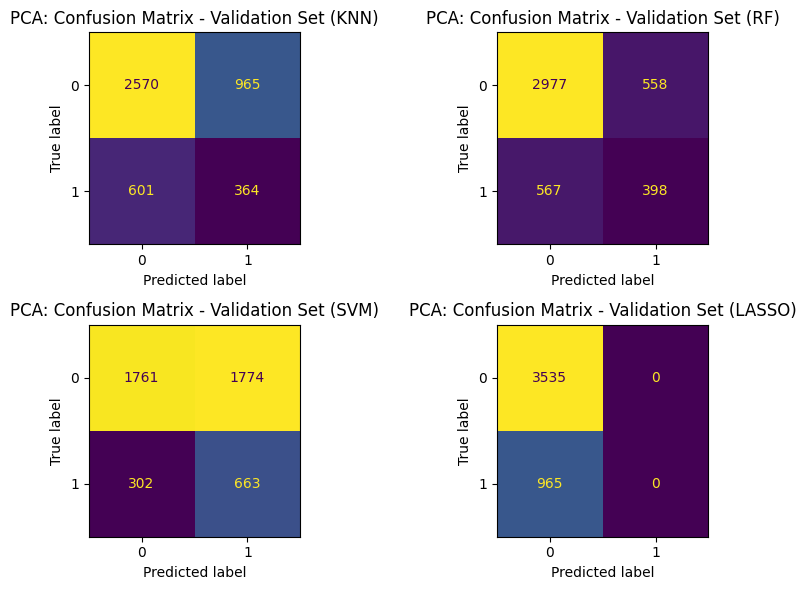

In [80]:
fig, axes = plt.subplots(2, 2, figsize=(9, 6))

# Using SMOTE+PCA models
# --- KNN ---
y_val_pred_smt_pca = best_knn_smt_pca.predict(df_PCA_X_val)
cm_val = confusion_matrix(y_val, y_val_pred_smt_pca)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(ax=axes[0, 0], colorbar=False)
axes[0, 0].set_title('PCA: Confusion Matrix - Validation Set (KNN)')

# --- RF ---
y_val_pred_rf_smt_pca = best_rf_smt_pca.predict(df_PCA_X_val)
cm_val_rf = confusion_matrix(y_val, y_val_pred_rf_smt_pca)
disp_val_rf = ConfusionMatrixDisplay(confusion_matrix=cm_val_rf)
disp_val_rf.plot(ax=axes[0, 1], colorbar=False)
axes[0, 1].set_title('PCA: Confusion Matrix - Validation Set (RF)')

# --- SVM ---
y_val_pred_svm_smt_pca = best_svm_smt_pca.predict(df_PCA_X_val)
cm_val_svm = confusion_matrix(y_val, y_val_pred_svm_smt_pca)
disp_val_svm = ConfusionMatrixDisplay(confusion_matrix=cm_val_svm)
disp_val_svm.plot(ax=axes[1, 0], colorbar=False)
axes[1, 0].set_title('PCA: Confusion Matrix - Validation Set (SVM)')

# --- LASSO ---
y_val_pred_lasso_smt_pca = lasso_rec_smt_pca.predict(df_PCA_X_val) #Should chose the C which maximizes recall. Below is the C value used. Check it if in doubt
#print(lasso.C_)
cm_val_lasso = confusion_matrix(y_val, y_val_pred_lasso_smt_pca)
disp_val_lasso = ConfusionMatrixDisplay(confusion_matrix=cm_val_lasso)
disp_val_lasso.plot(ax=axes[1, 1], colorbar=False)
axes[1, 1].set_title('PCA: Confusion Matrix - Validation Set (LASSO)')

# Adjust layout
plt.tight_layout()
plt.show()

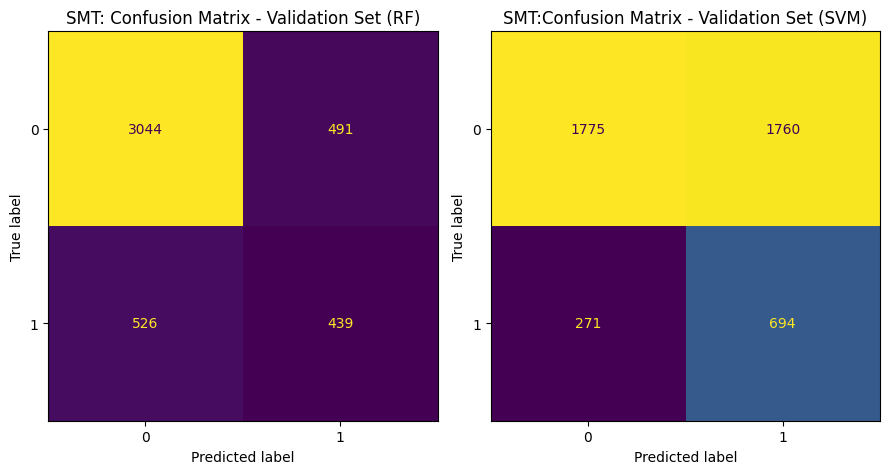

In [166]:
fig, axes = plt.subplots(1, 2, figsize=(9, 6))

# Using SMOTE models
# --- RF ---
y_val_pred_rf_smt = best_rf_smt.predict(X_val)
cm_val_rf = confusion_matrix(y_val, y_val_pred_rf_smt)
disp_val_rf = ConfusionMatrixDisplay(confusion_matrix=cm_val_rf)
disp_val_rf.plot(ax=axes[0], colorbar=False)
axes[0].set_title('SMT: Confusion Matrix - Validation Set (RF)')

# --- SVM ---
y_val_pred_svm_smt = best_svm_smt.predict(X_val)
cm_val_svm = confusion_matrix(y_val, y_val_pred_svm_smt)
disp_val_svm = ConfusionMatrixDisplay(confusion_matrix=cm_val_svm)
disp_val_svm.plot(ax=axes[1], colorbar=False)
axes[1].set_title('SMT:Confusion Matrix - Validation Set (SVM)')


# Adjust layout
plt.tight_layout()
plt.show()

In [168]:
# ========================
# RAW models
# ========================
# --- KNN ---
y_val_pred = best_knn.predict(X_val)
# --- RF ---
y_val_pred_rf = best_rf.predict(X_val)
# --- SVM ---
y_val_pred_svm = best_svm.predict(X_val)
# --- LASSO ---
y_val_pred_lasso = lasso_rec.predict(X_val)
# Recall scores (SMT)
recall_knn   = recall_score(y_val, y_val_pred)
recall_rf    = recall_score(y_val, y_val_pred_rf)
recall_svm   = recall_score(y_val, y_val_pred_svm)
recall_lasso = recall_score(y_val, y_val_pred_lasso)



# ========================
# PCA models
# ========================
# --- KNN ---
y_val_pred_pca = best_knn_pca.predict(df_PCA_X_val)
# --- RF ---
y_val_pred_rf_pca = best_rf_pca.predict(df_PCA_X_val)
# --- SVM ---
y_val_pred_svm_pca = best_svm_pca.predict(df_PCA_X_val)
# --- LASSO ---
y_val_pred_lasso_pca = lasso_rec_pca.predict(df_PCA_X_val)
# Recall scores (PCA)
recall_knn_pca   = recall_score(y_val, y_val_pred_pca)
recall_rf_pca    = recall_score(y_val, y_val_pred_rf_pca)
recall_svm_pca   = recall_score(y_val, y_val_pred_svm_pca)
recall_lasso_pca = recall_score(y_val, y_val_pred_lasso_pca)


# ========================
# SMOTE models
# ========================
# --- KNN ---
y_val_pred_smt = best_knn_smt.predict(X_val)
# --- RF ---
y_val_pred_rf_smt = best_rf_smt.predict(X_val)
# --- SVM ---
y_val_pred_svm_smt = best_svm_smt.predict(X_val)
# --- LASSO ---
y_val_pred_lasso_smt = best_lasso_smt.predict(X_val)
# Recall scores (SMT)
recall_knn_smt   = recall_score(y_val, y_val_pred_smt)
recall_rf_smt    = recall_score(y_val, y_val_pred_rf_smt)
recall_svm_smt   = recall_score(y_val, y_val_pred_svm_smt)
recall_lasso_smt = recall_score(y_val, y_val_pred_lasso_smt)



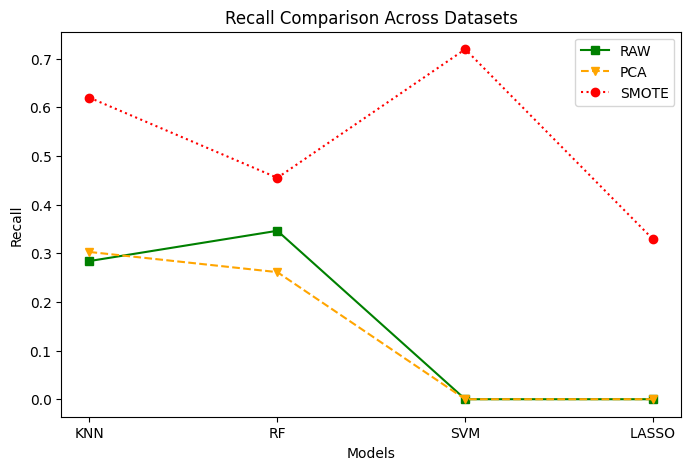

In [177]:
models = ["KNN", "RF", "SVM", "LASSO"]

recalls_raw  = [recall_knn, recall_rf, recall_svm, recall_lasso]
recalls_pca  = [recall_knn_pca, recall_rf_pca, recall_svm_pca, recall_lasso_pca]
recalls_smt  = [recall_knn_smt, recall_rf_smt, recall_svm_smt, recall_lasso_smt]

plt.figure(figsize=(8,5))

# Plot lines
plt.plot(models, recalls_raw, marker="s", linestyle="-", color="green", label="RAW")

# Plot PCA with dashed line and triangle marker
plt.plot(models, recalls_pca, marker="v", linestyle="--", color="orange", label="PCA")

# Plot SMOTE with dotted line and circle marker
plt.plot(models, recalls_smt, marker="o", linestyle=":", color="red", label="SMOTE")

# Labels and legend
plt.xlabel("Models")
plt.ylabel("Recall")
plt.title("Recall Comparison Across Datasets")
plt.legend()
plt.show()

In [173]:
accuracy_knn   = accuracy_score(y_val, y_val_pred)
accuracy_rf    = accuracy_score(y_val, y_val_pred_rf)
accuracy_svm   = accuracy_score(y_val, y_val_pred_svm)
accuracy_lasso = accuracy_score(y_val, y_val_pred_lasso)

# Similarly for PCA models
accuracy_knn_pca   = accuracy_score(y_val, y_val_pred_pca)
accuracy_rf_pca    = accuracy_score(y_val, y_val_pred_rf_pca)
accuracy_svm_pca   = accuracy_score(y_val, y_val_pred_svm_pca)
accuracy_lasso_pca = accuracy_score(y_val, y_val_pred_lasso_pca)

# And for SMOTE models
accuracy_knn_smt   = accuracy_score(y_val, y_val_pred_smt)
accuracy_rf_smt    = accuracy_score(y_val, y_val_pred_rf_smt)
accuracy_svm_smt   = accuracy_score(y_val, y_val_pred_svm_smt)
accuracy_lasso_smt = accuracy_score(y_val, y_val_pred_lasso_smt)

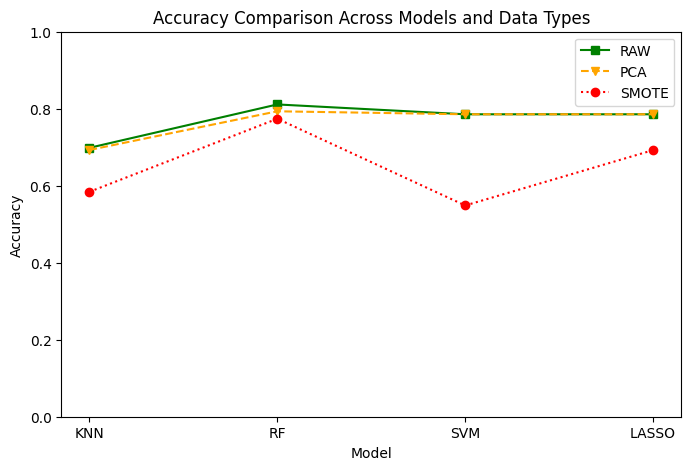

In [176]:
models = ["KNN", "RF", "SVM", "LASSO"]

recalls_raw  = [accuracy_knn, accuracy_rf, accuracy_svm, accuracy_lasso]
recalls_pca  = [accuracy_knn_pca, accuracy_rf_pca, accuracy_svm_pca, accuracy_lasso_pca]
recalls_smt  = [accuracy_knn_smt, accuracy_rf_smt, accuracy_svm_smt, accuracy_lasso_smt]

plt.figure(figsize=(8,5))

# Plot lines
plt.plot(models, recalls_raw, marker="s", linestyle="-", color="green", label="RAW")

# Plot PCA with dashed line and triangle marker
plt.plot(models, recalls_pca, marker="v", linestyle="--", color="orange", label="PCA")

# Plot SMOTE with dotted line and circle marker
plt.plot(models, recalls_smt, marker="o", linestyle=":", color="red", label="SMOTE")


# Labels and legend
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.title("Accuracy Comparison Across Models and Data Types")
plt.legend()

In [178]:
X_test = test.iloc[:, 1:-1]
y_test = test.iloc[:, -1]

# Combine training and validation data
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# Refit best model (from recall tuning) on the combined set
final_rf_smt = best_rf_smt.set_params(**grid_rf_rec_smt.best_params_)
final_rf_smt.fit(X_train_val, y_train_val)

y_test_pred_rf_smt = final_rf_smt.predict(X_test)

# Estimate recall
recall_rf_smt_test = recall_score(y_test, y_test_pred_rf_smt)
acc_rf_smt_test = accuracy_score(y_test, y_test_pred_rf_smt)
print("Test Accuracy (RF, SMOTE, best recall hyperparameters):", acc_rf_smt_test)
print("Test Recall (RF, SMOTE, best recall hyperparameters):", recall_rf_smt_test)

Test Accuracy (RF, SMOTE, best recall hyperparameters): 0.782
Test Recall (RF, SMOTE, best recall hyperparameters): 0.48743718592964824


In [180]:
rf_model = final_rf_smt.named_steps['rf']

# Now you can get feature importances
importances = rf_model.feature_importances_
feature_names = X_train_val.columns

# Create DataFrame
import pandas as pd
feat_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# Display top 10 features
print(feat_importances.head(20))

      Feature  Importance
5       PAY_0    0.077387
0   LIMIT_BAL    0.061466
11  BILL_AMT1    0.057504
17   PAY_AMT1    0.054481
4         AGE    0.053956
18   PAY_AMT2    0.051632
6       PAY_2    0.050262
12  BILL_AMT2    0.049617
19   PAY_AMT3    0.046804
13  BILL_AMT3    0.046509
14  BILL_AMT4    0.044721
22   PAY_AMT6    0.044556
20   PAY_AMT4    0.044131
15  BILL_AMT5    0.043602
16  BILL_AMT6    0.043365
21   PAY_AMT5    0.041498
3    MARRIAGE    0.031361
7       PAY_3    0.029928
1         SEX    0.028739
8       PAY_4    0.027998
